## Analysing social media data for disaster management (Flooding) in kdb+

The European Frontier Development Lab (FDL) is a public, private partnership between top academic institutions, governmental institurions and leaders in technology and Artificial Intelligence (AI). FDL aims to apply AI to problems within the space sector using cutting edge hardware and machine learning solutions. 2019 is the 3rd year Kx has been involved with this program, this year working on disaster management and response problems both in the US and Europe. 

Annually flooding events on average affect 82.6 million people worldwide across all social classes and geographic locations. The work presented in this notebook outlines a method by which we can distinguish the characteristics of tweets relating to flooding events such that the different classes of tweets can be triaged accordingly

In conjunction with this a representation of a live scoring system built on top of a kdb+ tickerplant has been produced to show how the architecture for a live system could potentially be formatted.

## Notebook Preparation

Here we load the following scripts and libraries

* Kx Natural Language Processing Library
* Kx Machine Learning Toolkit
* Custom functionality related to this use case
* Functionality to save models and a tokenizer for use in the 'live' system

In [1]:
\l nlp/init.q
\l ml/ml.q
\l ../code/fdl_disasters.q
\l ../code/token_save.p
.ml.loadfile`:init.q

In the following cell load all the required python functionality for the following purposes

* Plotting
* Manipulate the text data to conform to input for the models
* Appropriate deep learning model layers

In [3]:
npa:.p.import[`numpy]`:array
plt:.p.import[`matplotlib.pyplot]
pd :.p.import[`pandas]

// Textual data preprocessing 
token:.p.import[`keras.preprocessing.text]`:Tokenizer
pad  :.p.import[`keras.preprocessing.sequence]`:pad_sequences

kl:{.p.import[`keras.layers]x}
// Keras layers used
seq    :.p.import[`keras.models]`:Sequential
dense  :kl`:Dense
embed  :kl`:Embedding
lstm   :kl`:LSTM
spdrop1:kl`:SpatialDropout1D
dropout:kl`:Dropout

## Data loading and pre-processing 

The following cell contains functions that are used to load the datasets used and rename columns such that there is consistency in naming convention between the disparate data sources

In [4]:
nms_1:{rename[;names]("j*SSS";enlist",")0:`$":../data/floods/",x}
nms_2:{("jSSIPSf*J*S";enlist",")0:`$":../data/floods/",x}

Load data from flooding events across socio-encomic and geographical border. These events are in:

1. Colorado, USA 
2. Queensland, Australia
3. Alberta, Canada
4. The Phillipines
5. India
6. Pakistan

In [5]:
co :nms_1["Developed/2013_Colorado_floods/2013_Colorado_floods-tweets_labeled.csv"]
qld:nms_1["Developed/2013_Queensland_floods/2013_Queensland_floods-tweets_labeled.csv"]
alb:nms_1["Developed/2013_Alberta_floods/2013_Alberta_floods-tweets_labeled.csv"]
ph :nms_1["Developing/2012_Philipinnes_floods/2012_Philipinnes_floods-tweets_labeled.csv"]
ind:nms_2["Developing/2014_India_floods/2014_india_floods.csv"]
pac:nms_2["Developing/2014_Pakistan_floods/2014_pakistan_floods.csv"]

Next the following steps are taken:

1. Create both a binary and multi-class dataset. Targets used for the creation of both a binary and multi-class model are encoded to ensure consistency between the two data-sources.
2. Capital letter are lowered
3. Un-labelled data is removed

For transparancy the following are the categories encoded within this target for the multi-class problem

1. Affected Individuals
2. Donations and Volunteering
3. Infrastructural Damage
4. Other Useful Information 
5. Caution and Advice
6. Not Applicable
7. Sympathy and Prayers

The binary classification problem bins 1->5 together into an `Affected Individuals` class while 6->7 are deemed `Not Applicable`

In [6]:
data_b:encodetgt[co,qld,alb,ph;encodebin],encodetgt[ind,pac;encodebin]
data_m:encodetgt[co,qld,alb,ph;encodemulti],encodetgt[ind,pac;encodemulti]

data_m[`tweet_text]:data_b[`tweet_text]:lower data_m`tweet_text

inds:exec i from data_m where target<>`not_labeled
data_b:data_b@inds
data_m:data_m@inds

Set up functions and parameters for the removal of the following from the dataset
* Web links
* Retweet flags
* Numbers
* Special characters including `{?,.:}`

In [7]:
rmv_list   :("http*";"rt";"*,";"*&*";"*[0-9]*")
rmv_single :rmv_master[;",.:?!/@'";""]
rmv_hashtag:rmv_master[;"#";""]

#### Data pre-manipulation

In [8]:
5#data_m`tweet_text

"rt @dlfluegge: crazy flooding in boulder, colorado http://t.co/sg0iidqcey vi..
"here's the #boulderflood video that's circulating around. right in my old ne..
"rt @passantino: video: severe flooding hits near univ. of colorado at boulde..
"crazy flooding in boulder, colorado http://t.co/3igoyaafwe"
"thoughts and prayers out to those in boulder who may not get to amante for m..


Remove non ascii, retweet tag, numerical values, emojis, hashtags and other unwanted characters

In [9]:
data_m[`tweet_text]:data_b[`tweet_text]:
 (rmv_ascii rmv_custom[;rmv_list] rmv_hashtag rmv_single@) each data_m`tweet_text

#### Data post-manipulation

In [10]:
5#data_m`tweet_text

"dlfluegge crazy flooding in boulder colorado via youtube"
"heres the boulderflood video thats circulating around right in my old neighb..
"passantino video severe flooding hits near univ of colorado at boulder"
"crazy flooding in boulder colorado"
"thoughts and prayers out to those in boulder who may not get to amante for m..


---

## Preliminary Data Exploration

The purpose of this section is to take a high level look at the data both in regards to the distribution of classes, explore what underlays the classes themselves and perform some rudimentary sentiment analysis on the data to find positive and negative tweets

### _Word cloud analysis_

In the following cells we display the most commonly associated words with a number of the classes within this dataset

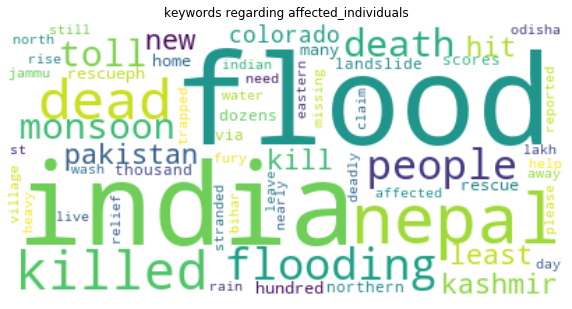

In [11]:
wordcloudfn[data_m;`affected_individuals]

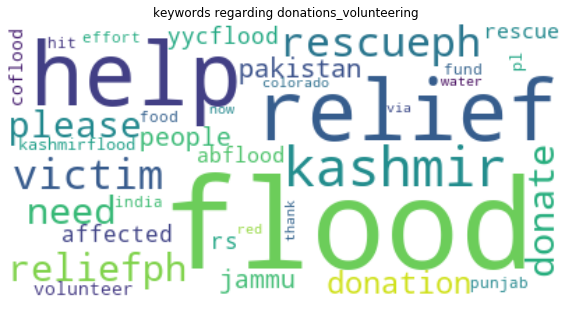

In [12]:
wordcloudfn[data_m;`donations_volunteering]

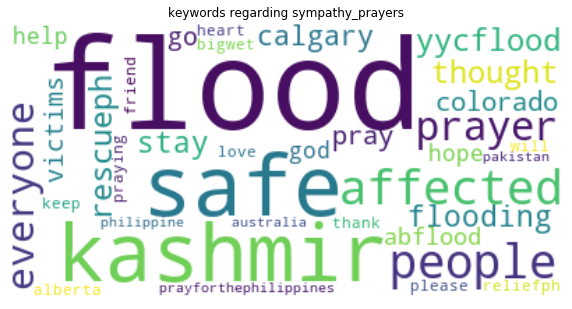

In [13]:
wordcloudfn[data_m;`sympathy_prayers]

Given the context of the tweets within the overall dataset it is not surprising that words such as flood and locations such as Pakistan and Kashmir are displayed within a number of the classes. However some displayed words are more informative to the classes,

* Donations or Volunteering:
    - affected, donate, rescue, volunteer, people
* Affected Individuals:
    - killed, dead, affected, missing, toll
* Sympathy/Prayers:
    - pray, safe, friend, thought, love
    
The presence of distinct words within each class lends credence to the idea that it should be possible to classify these tweets into their associated categories and generalise this method to new and larger datasets

### _Sentiment analysis_

The following cell uses the Kx NLP Library to source tweets that have a positive or negative sentiment.

This allows us to gain some understanding of the state of mind of those individuals affected by the crises

In [14]:
sentiment:.nlp.sentiment each data_m`tweet_text

\c 200 200

5?100#data_m[`tweet_text] idesc sentiment`compound
5?100#data_m[`tweet_text] iasc  sentiment`compound

\c 20 90

"solid_abscbn dont panic to this genesis god promised to never do that again think positive be positive pinoys rescueph"
"solid_abscbn dont panic to this genesis god promised to never do that again think positive be positive pinoys rescueph"
"garysnowpatrol just seen the floods in manila on tv sweet jesus i sincerely hope you and your loved ones are safe didnt realize"
"major_amkhan proudly serving pakistan satisfaction while helping your countrymen at the time of need help the flood victims"
"j-k floods un system stands ready to help india pakistan the un system stands ready to help governments in"


"bihar of a family killed as train hits auto - hindustan times times of indiabihar of a family killed"
"homes damaged in coflood businesses destroyed about with damage less than people still missing"
"bihar of a family killed as train hits auto - hindustan times times of indiabihar of a family killed"
"nepal and india floods leave many dead at least people are reported to have been killed in floods and lan"
"news asia floods kill in eastern india - flooding in eastern india has killed people and displaced more th"


### _Category distribution metrics_

One important aspect of training machine learning models is an understanding of the distributions of categories within the datasets. 

This provides a pseudo benchmark from which we can assess the ability of the models to correctly categorize differing classes. 

##### Binary class label distribution 

In [15]:
distrib_b:desc count each group data_b`target

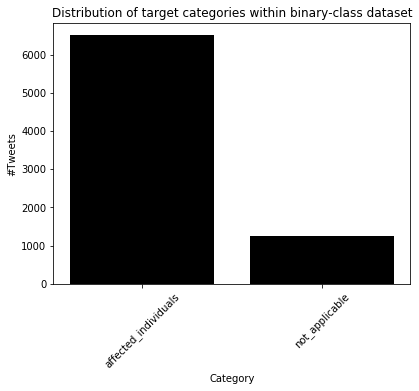

In [16]:
plt[`:bar][til count distrib_b;value distrib_b;`color pykw `k];
plt[`:title][`$"Distribution of target categories within binary-class dataset"];
plt[`:xlabel][`Category];
plt[`:xticks][til count distrib_b;key distrib_b;`rotation pykw `45];
plt[`:ylabel][`$"#Tweets"];
plt[`:show][];

##### Multi class label distribution

In [17]:
distrib_m:desc count each group data_m`target

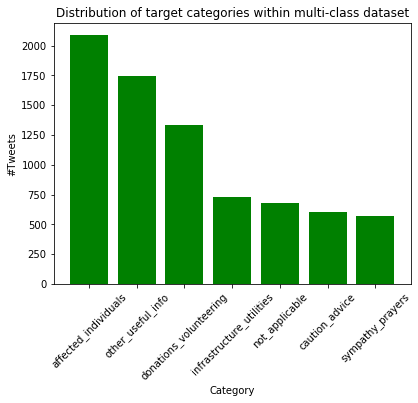

In [18]:
plt[`:bar][til count distrib_m;value distrib_m;`color pykw `g];
plt[`:title][`$"Distribution of target categories within multi-class dataset"];
plt[`:xlabel][`Category];
plt[`:xticks][til count distrib_m;key distrib_m;`rotation pykw `45];
plt[`:ylabel][`$"#Tweets"];
plt[`:show][];

---

## Data Preparation and Model Description

While there are a vast number of data preparation techniques and models that can be used for the classification of textual data as an academic exercise a deep learning approach using LSTMs was taken here.

A number of data preparation steps need to be taken to ensure this can be achieved.

1. Data is tokenized with numerical values (indices in the corpus) associated with individual words
2. Each vector sentence is padded with leading zeros to ensure consistency of length

These preparation steps are consistent for both the binary and multi-class and as such only completed once. 

In [19]:
max_nb_words:2000
max_seq_len :50

tweet_vals :npa data_b`tweet_text
tokenizer:token[`num_words pykw max_nb_words;`lower pykw 1b]
tokenizer[`:fit_on_texts]tweet_vals;

Save tokenizer to be used on 'live system'

In [20]:
sv_tok:.p.get[`save_token]
sv_tok[tokenizer];

Tokenize the text data to produce a padded numerical representation of the data for both the binary and multi-class data

In [21]:
X:tokenizer[`:texts_to_sequences]tweet_vals
X:pad[X;`maxlen pykw max_seq_len]`

Y_b:flip value ohe_b:.ml.i.onehot1 data_b`target
Y_m:flip value ohe_m:.ml.i.onehot1 data_m`target

Split both the datasets into training and testing sets in a 90% - 10% split

In [22]:
tts_b:.ml.traintestsplit[X;Y_b;0.1]
xtrn_b:tts_b`xtrain;ytrn_b:tts_b`ytrain
xtst_b:tts_b`xtest;ytst_b:tts_b`ytest

tts_m:.ml.traintestsplit[X;Y_m;0.1]
xtrn_m:tts_m`xtrain;ytrn_m:tts_m`ytrain
xtst_m:tts_m`xtest;ytst_m:tts_m`ytest

---

## Models

The models used for both the classification tasks are Long short-term memory(LSTM) models. This form of deep learning neural network architecture is an artificial recurrent neural network. 

This uses a structure known as a memory cell to regulate gradients within the system and avoid the problems of [exploding](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/) and [vanishing](https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484) gradients which can occur in traditional recurrent neural networks during back propogation.

<img src="imgs/lstm_memorycell.png" style="height:200px">

<b><u><center>LSTM Memory Cell Example</center></u></b>

In essence the memory cell is responsible for maintaining knowledge of the dependancies between elements of the input sequence. The gates of these cells operate broadly as follows:

1. Input Gate: Controls how new information flows into the cell
2. Forget Gate: Controls how long a value from the input gate stays in the cell (memory)
3. Output Gate: Controls how the cell value is used to compute the activation of an LSTM unit

### Model Parameters

In [23]:
batch_sz    :64    // Number of samples processed independently in parallel
embed_dim   :100   // Shape of the input dataset
epochs      :10    // Number of times runs over the dataset of the model

### Model Architectures

Both the binary and multi-class models exhibit the same general stucture outlined as follows with minor modifications to numbers of nodes and degree of dropout to tune the model

1. Embedding layer: Input parameters for the model, sequence length, output dimension for embedding etc.
2. 1D Spatial dropout layer: Dropout 1D [feature maps](https://stats.stackexchange.com/questions/291820/what-is-the-definition-of-a-feature-map-aka-activation-map-in-a-convolutio) from input, this promotes independence between feature maps and thus regulates overfitting
3. LSTM layer: 
    1. Define the dimensionality of the output space 
    2. Dropout a fraction of the data during a linear transformation of inputs
    3. Recurrent Dropout defines the percentage of data to drop during recurrent state linear transformation
4. Dense layer: This defines the number of outputs expected from the model (Classes) and the activation function which defines cutoffs for the boundaries between classes
5. Compile layer: This configures the model for training including how optimization is to completed and based on what metrics

**Binary Classification Model**

In [25]:
mdl_b:seq[];
mdl_b[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X)1]];
mdl_b[`:add]spdrop1[0.2];
mdl_b[`:add]lstm[100;pykwargs `dropout`recurrent_dropout!(0.2;0.2)];
mdl_b[`:add]dense[2;`activation pykw `sigmoid];
mdl_b[`:compile][pykwargs `loss`optimizer`metrics!(`binary_crossentropy;`adam;enlist `accuracy)];
print mdl_b[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 280,602
Trainable params: 280,602
Non-trainable params: 0
_________________________________________________________________
None


**Multi-Class Model**

In [26]:
mdl_m:seq[];
mdl_m[`:add][embed[max_nb_words;embed_dim;`input_length pykw (.ml.shape X)1]];
mdl_m[`:add]spdrop1[0.1];
mdl_m[`:add]lstm[100;pykwargs `dropout`recurrent_dropout!(0.1;0.1)];
mdl_m[`:add]dense[7;`activation pykw `sigmoid];
mdl_m[`:compile][pykwargs `loss`optimizer`metrics!(`categorical_crossentropy;`adam;enlist `accuracy)];
print mdl_m[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           200000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 281,107
Trainable params: 281,107
Non-trainable params: 0
_________________________________________________________________
None


---

## Model Training

Here we train both models on 90% of the dataset, in the interest of avoiding cluttering this notebook verbosity is set to 0, if you wish to see the outputs at each step this can be set to 1

**Binary Classification Model**

In [28]:
strt:.z.t
mdl_b[`:fit][npa xtrn_b;npa ytrn_b;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;


Training time = 00:01:27.150


**Multi Classification Model**

In [29]:
strt:.z.t
mdl_m[`:fit][npa xtrn_m;npa ytrn_m;`epochs pykw epochs;`verbose pykw 0];
-1"\nTraining time = ",string .z.t-strt;


Training time = 00:01:27.606


## Results

In the interest of avoiding code repetition and thus improve structure of this notebook the function to complete the scoring of the models produced and fit above have been wrapped in the function `class_scoring`

This function completes the following and can be modified by a user in `../code/fdl_disasters.q`

1. Present the mapping between classes and their numeric representation as seen by the model, this is defined through the one hot encoding completed previously
2. Display the actual class compared to predicted class
3. Display the accuracy showing how well each class is being predicted
4. Produce a confusion matrix for the classes
5. Create a classification showing precision, recall and f1 score for each class. These are informative scores which outline the performance and shortcomings of the model


* Inputs: X-test, Y-Test, Model, One-hot encoding of class labels

**Binary Classification Results**

In [30]:
class_scoring[xtst_b;ytst_b;mdl_b;ohe_b]


The following is the integer mapping between class integer representation and real class value:

affected_individuals| 0
not_applicable      | 1

Actual Class vs prediction

Class Prediction Hit
--------------------
0     0          1  
0     0          1  
1     1          1  
0     0          1  
0     0          1  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss      
-----| --------------------
0    | 0.9550225 0.04497751
1    | 0.6111111 0.3888889 
TOTAL| 0.9070968 0.09290323

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1
-----| -------------
0    | 637    30    
1    | 42     66    

Classification report showing precision, recall and f1-score for each class:



class               | precision recall    f1_score  support
--------------------| -------------------------------------
affected_individuals| 0.9381443 0.9550225 0.9465082 667    
not_applicable      | 0.6875    0.6111111 0.6470588 108    
avg/total           | 0.8128222 0.7830668 0.7967835 775    


**Multi Classification Results**

In [31]:
class_scoring[xtst_m;ytst_m;mdl_m;ohe_m]


The following is the integer mapping between class integer representation and real class value:

affected_individuals    | 0
caution_advice          | 1
donations_volunteering  | 2
infrastructure_utilities| 3
not_applicable          | 4
other_useful_info       | 5
sympathy_prayers        | 6

Actual Class vs prediction

Class Prediction Hit
--------------------
0     0          1  
2     2          1  
2     0          0  
4     4          1  
5     3          0  

Displaying percentage of Correct prediction vs misses per class:

Class| Hit       Miss     
-----| -------------------
0    | 0.8831776 0.1168224
1    | 0.5625    0.4375   
2    | 0.7424242 0.2575758
3    | 0.4756098 0.5243902
4    | 0.7068966 0.2931034
5    | 0.5906433 0.4093567
6    | 0.6666667 0.3333333
TOTAL| 0.6967742 0.3032258

Displaying predicted vs actual class assignment matrix:

Class| Pred_0 Pred_1 Pred_2 Pred_3 Pred_4 Pred_5 Pred_6
-----| ------------------------------------------------
0    | 189    3      6 

class                   | precision recall    f1_score  support
------------------------| -------------------------------------
affected_individuals    | 0.8076923 0.8831776 0.84375   214    
caution_advice          | 0.5373134 0.5625    0.5496183 64     
donations_volunteering  | 0.7368421 0.7424242 0.7396226 132    
infrastructure_utilities| 0.6724138 0.4756098 0.5571429 82     
not_applicable          | 0.8039216 0.7068966 0.7522936 58     
other_useful_info       | 0.583815  0.5906433 0.5872093 171    
sympathy_prayers        | 0.6101695 0.6666667 0.6371681 54     
avg/total               | 0.6788811 0.6611312 0.6666864 775    


---

## Conclusions

In conclusion it is clear from the results above that the use of an LSTM architecture to create a classifier for tweet content was braodly success. 

In the case of the binary classifier accuracies in the region of 91% shows that the model was capable of discerning between relevant and irrelevant tweets. More informative however is the recall on the affected individuals class which was 95%, as such we are only missing 5% of the total true positives of affected individuals.

The multiclass example Also appears to be working well with overall accuracy of ~70%. Recall in the most important category affected individuals which was ~88%. The most common misclassification was the classification of 'infrastructure/utilities' damage as 'other useful information'.

A number of limiting factors hamper the ability to create a better model with the data available, these are as follows:

1. The dataset used was limited in size only 7800 classified tweets were available, given the 'noisy' nature of tweets this creates difficulties around producing a reliable model. A larger corpus would likely produce a better model
2. The human annotated data can be unreliable, while the data was collected and tagged by CrisisNLP given the similarity of some of the classes it may be the case that mistakes being made by the model are accurate representation of the true class
3. Decisions regarding information to remove from the dataset can have an impact, the inclusion of hashtags or the removal of user handles or rt tags can have an impact on the models ability to derive context from the tweets

The running of a 'live' system can be compeleted by following the instructions in the `README.md` provided at the root of this directory github.

**Save multi-class classification model as h5 for use in 'live system'**

In [ ]:
mdl_m[`:save]["../live/multiclass_mdl.h5"]

---